In [19]:
import os
import sys
import re
import copy
import math


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from operator import itemgetter
from itertools import groupby

from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor, ARDRegression, BayesianRidge,OrthogonalMatchingPursuit, PoissonRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import VotingRegressor

In [2]:
#Data visualization
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.01, '#404388'),
    (0.05, '#2a788e'),
    (0.1, '#21a784'),
    (0.2, '#78d151'),
    (1, '#fde624'),
], N=16384)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
    plt.plot([-50.0,800.0], [-50.0,800.0], "--", color = "Black")
    #plt.plot([-50.0,800.0], [-80.0,770.0], "--", color = "Grey")
    #plt.plot([-50.0,800.0], [-20.0,830.0], "--", color = "Grey")
    plt.ylabel('Predicted WC')
    plt.xlabel('Real data WC')
    plt.xlim(-50,800)
    plt.ylim(-50,800)
    
fig = plt.figure(figsize=(12,10))

<Figure size 864x720 with 0 Axes>

## import data V.6 (trian,val,test)

In [3]:
train_path = os.path.join(".", "main/train_Pcue/dataset_test_6_RDF 4", "trainset.csv")
print("Read the training dataset from %s" %(train_path))
val_path = os.path.join(".", "main/train_Pcue/dataset_test_6_RDF 4", "testset.csv")
print("Read the pretesting dataset from %s" %(val_path))
test_path = os.path.join(".", "main/train_Pcue/dataset_test_6_RDF 4", "test_fixed.csv")
print("Read the pretesting dataset from %s" %(test_path))

Read the training dataset from ./main/train_Pcue/dataset_test_6_RDF 4/trainset.csv
Read the pretesting dataset from ./main/train_Pcue/dataset_test_6_RDF 4/testset.csv
Read the pretesting dataset from ./main/train_Pcue/dataset_test_6_RDF 4/test_fixed.csv


In [4]:
train_set = pd.read_csv(train_path)
val_set = pd.read_csv(val_path)
test_set = pd.read_csv(test_path)

In [5]:
Cols1= ['volume [A^3]', 'weight [u]', 'surface_area [m^2/g]',
       'void_fraction', 'void_volume [cm^3/g]',
       'CO2/N2_selectivity', 'heat_adsorption_CO2_P0.15bar_T298K [kcal/mol]',
       'density [g/cm^3]',
        
        'NUM_ATOMS', 'a', 'b', 'c', 'abc', 'alpha', 'beta',
       'gamma', 'alpha-beta-gamma', 'DEG_UNSAT', 'DEG_UNSAT_C', 'METAL_C',
       'O_METAL', 'ELEC_FRAC', 'W_ELEC', 'O_C', 'N_C', 'N_O', 
        
       'n_m','n_ml_m_n','_n_ol1','_n_ol2', '_n_fg1', '_n_fg2',
       
        'H', 'P', 'V', 'Zn', 'C', 'Ba','N', 'Br', 'S', 'Ni', 'I', 'Cl', 'F', 'Cr', 'O', 'Cu', 
        
       'RDF-0-1', 'RDF-0-2', 'RDF-0-3', 'RDF-2-1', 'RDF-2-2', 'RDF-2-3',
       'RDF-5-1', 'RDF-5-2', 'RDF-5-3', 'RDF-10-1', 'RDF-10-2', 'RDF-10-3',
       'RDF-20-1', 'RDF-20-2', 'RDF-20-3', 'RDF-30-1', 'RDF-30-2', 'RDF-30-3',
       'RDF-15-1', 'RDF-15-2', 'RDF-15-3', 'RDF-25-1', 'RDF-25-2', 'RDF-25-3',
       'RDF-22-1', 'RDF-22-2', 'RDF-22-3', 'RDF-24-1', 'RDF-24-2', 'RDF-24-3',
       'RDF-4-1', 'RDF-4-2', 'RDF-4-3', 'RDF-6-1', 'RDF-6-2', 'RDF-6-3',
       'RDF-8-1', 'RDF-8-2', 'RDF-8-3', 'RDF-12-1', 'RDF-12-2', 'RDF-12-3',
       'RDF-14-1', 'RDF-14-2', 'RDF-14-3', 'RDF-16-1', 'RDF-16-2', 'RDF-16-3',
       'RDF-18-1', 'RDF-18-2', 'RDF-18-3', 'RDF-3-1', 'RDF-3-2', 'RDF-3-3',
       'RDF-7-1', 'RDF-7-2', 'RDF-7-3', 'RDF-9-1', 'RDF-9-2', 'RDF-9-3',
       'RDF-11-1', 'RDF-11-2', 'RDF-11-3', 'RDF-13-1', 'RDF-13-2', 'RDF-13-3',
       'RDF-17-1', 'RDF-17-2', 'RDF-17-3', 'RDF-19-1', 'RDF-19-2', 'RDF-19-3',
       'RDF-23-1', 'RDF-23-2', 'RDF-23-3', 'RDF-27-1', 'RDF-27-2', 'RDF-27-3',
       'RDF-29-1', 'RDF-29-2', 'RDF-29-3', 'RDF-21-1', 'RDF-21-2', 'RDF-21-3', 
       'RDF-26-1', 'RDF-26-2', 'RDF-26-3', 'RDF-28-1', 'RDF-28-2', 'RDF-28-3', 
       'RDF-2.5-1', 'RDF-2.5-2','RDF-2.5-3', 'RDF-3.5-1', 'RDF-3.5-2', 'RDF-3.5-3', 
       'RDF-4.5-1','RDF-4.5-2', 'RDF-4.5-3']

In [7]:
X_train_set = train_set[Cols1]
X_val_set = val_set[Cols1]
X_test_set = test_set[Cols1]
Y_train_set = pd.DataFrame(train_set['CO2_working_capacity [mL/g]'])
Y_val_set = pd.DataFrame(val_set['CO2_working_capacity [mL/g]'])

In [10]:
#Change X,Y to array
X_train = X_train_set.values
Y_train = Y_train_set.iloc[:,0]
X_test = X_val_set.values
Y_test = Y_val_set.iloc[:,0]
X_realtest = X_test_set.values

In [11]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_realtest = sc.transform(X_realtest)

In [12]:
X_all = np.concatenate((X_train, X_test), axis=0)
Y_all = np.concatenate((Y_train, Y_test), axis=0)

## Random Forest

In [ ]:
# optimize hyperparameters
param_grid = {'max_depth': [15,16,17,18,19,20],
              'max_features': [44,45,46],
              'n_estimators':[10],
             }
 
grid = GridSearchCV(RandomForestRegressor(), param_grid, refit = True, verbose = 3)
 
grid.fit(X_all, Y_all)
print(grid.best_params_)

In [13]:
rf = RandomForestRegressor(max_depth=19, max_features=45,n_estimators=150, random_state=1)
rf.fit(X_train, Y_train)
print(rf) 

Y_pred_train = rf.predict(X_train)

print('RMSE: %.10f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))
print('R^2: %.10f'
      % r2_score(Y_train, Y_pred_train))
print('MAE: %.10f'
      % mean_absolute_error(Y_train, Y_pred_train))
print('LMAE: %.10f'
      % np.log10(mean_absolute_error(Y_train, Y_pred_train)))
print("-------------")

Y_pred_test = rf.predict(X_test)

print('RMSE: %.10f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))
print('R^2: %.10f'
      % r2_score(Y_test, Y_pred_test))
print('MAE: %.10f'
      % mean_absolute_error(Y_test, Y_pred_test))
print('LMAE: %.10f'
      % np.log10(mean_absolute_error(Y_test, Y_pred_test)))
print("-------------")

RandomForestRegressor(max_depth=19, max_features=45, n_estimators=150,
                      random_state=1)
RMSE: 12.5870789167
R^2: 0.9797271101
MAE: 9.0380161373
LMAE: 0.9560731124
-------------
RMSE: 29.7676232067
R^2: 0.8860407502
MAE: 20.4529464681
LMAE: 1.3107558817
-------------


/Users/chayanonatthapak/Downloads/return/envs/nn_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/chayanonatthapak/Downloads/return/envs/nn_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


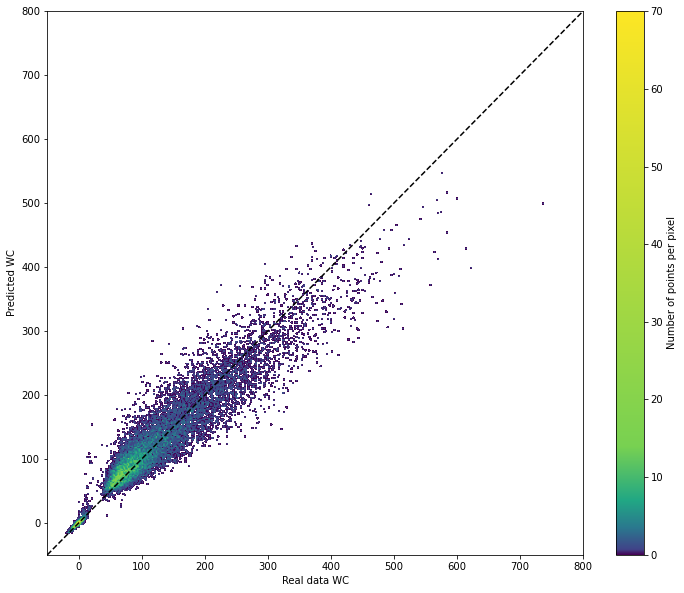

In [14]:
fig = plt.figure(figsize=(12,10))
using_mpl_scatter_density(fig, Y_test, Y_pred_test)

<AxesSubplot:>

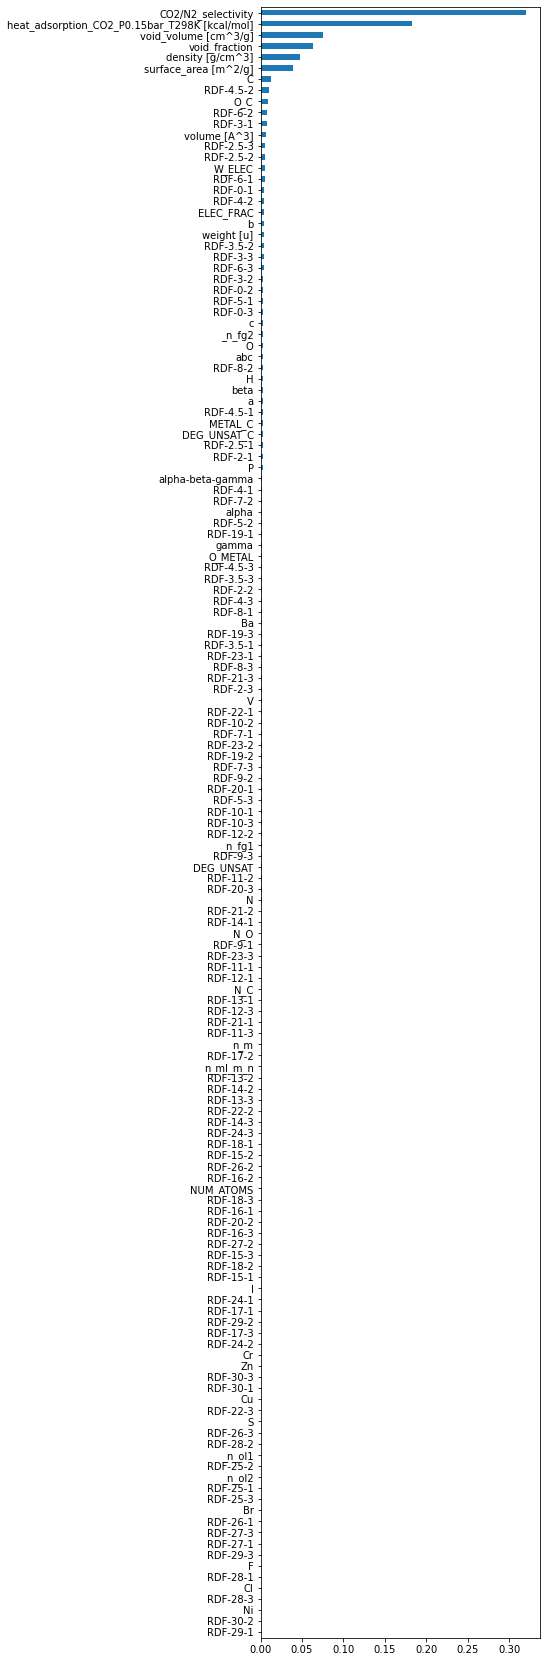

In [15]:
fs=pd.Series(rf.feature_importances_, index=Cols1).sort_values(ascending=True)
plt.figure(figsize=(5,30))
fs.plot(kind='barh')

## Gradient Boosting

In [ ]:
# optimize hyperparameters
param_grid = {'max_depth': [8,9,10,11,12],
              'max_features': [16,17,18],
              'learning_rate': [0.08,0.09,0.1],
              'n_estimators':[100],
              'random_state':[1],
             }
 
grid = GridSearchCV(GradientBoostingRegressor(), param_grid, refit = True, verbose = 3, cv=3)
 
# fitting the model for grid search
grid.fit(X_all, Y_all)
print(grid.best_params_)

In [16]:
gb = GradientBoostingRegressor(max_depth=9, max_features=17,learning_rate=0.09,n_estimators=150, random_state=1)
gb.fit(X_train, Y_train)
print(gb) 

Y_pred_train = gb.predict(X_train)

print('RMSE: %.10f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))
print('R^2: %.10f'
      % r2_score(Y_train, Y_pred_train))
print('MAE: %.10f'
      % mean_absolute_error(Y_train, Y_pred_train))
print('LMAE: %.10f'
      % np.log10(mean_absolute_error(Y_train, Y_pred_train)))
print("-------------")

Y_pred_test = gb.predict(X_test)

print('RMSE: %.10f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))
print('R^2: %.10f'
      % r2_score(Y_test, Y_pred_test))
print('MAE: %.10f'
      % mean_absolute_error(Y_test, Y_pred_test))
print('LMAE: %.10f'
      % np.log10(mean_absolute_error(Y_test, Y_pred_test)))
print("-------------")

GradientBoostingRegressor(learning_rate=0.09, max_depth=9, max_features=17,
                          n_estimators=150, random_state=1)
RMSE: 16.1447198292
R^2: 0.9666476241
MAE: 11.9305023497
LMAE: 1.0766587306
-------------
RMSE: 28.3268073172
R^2: 0.8968055077
MAE: 19.6649758044
LMAE: 1.2936934164
-------------


/Users/chayanonatthapak/Downloads/return/envs/nn_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/chayanonatthapak/Downloads/return/envs/nn_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


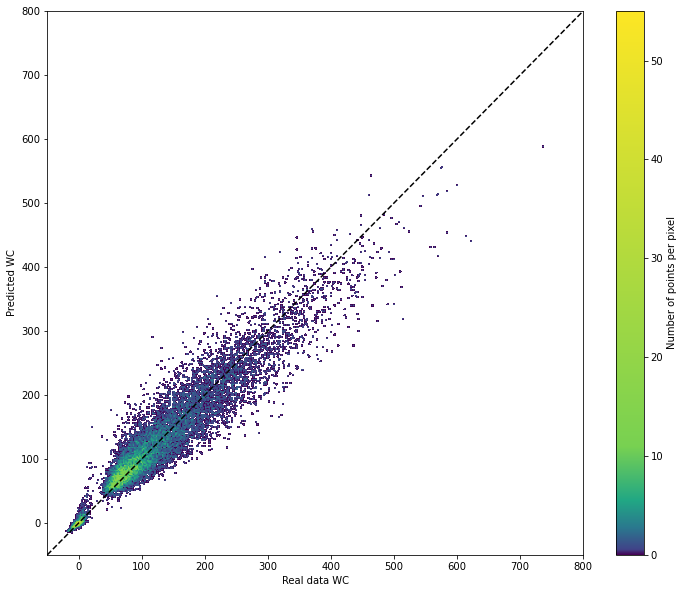

In [17]:
fig = plt.figure(figsize=(12,10))
using_mpl_scatter_density(fig, Y_test, Y_pred_test)

## Extra Trees Regressor

In [ ]:
# optimize hyperparameters
param_grid = {'max_depth': [50,60],
              'max_features': [50,60],
              'n_estimators':[50],
              'random_state':[1],
             }
 
grid = GridSearchCV(ExtraTreesRegressor(), param_grid, refit = True, verbose = 3)
 
grid.fit(X_all, Y_all)
print(grid.best_params_)

In [20]:
et = ExtraTreesRegressor(max_depth=50, max_features=60,n_estimators=300, random_state=1)
et.fit(X_train, Y_train)
print(et) 

Y_pred_train = et.predict(X_train)

print('RMSE: %.10f'
      % mean_squared_error(Y_train, Y_pred_train,squared=False))
print('R^2: %.10f'
      % r2_score(Y_train, Y_pred_train))
print('MAE: %.10f'
      % mean_absolute_error(Y_train, Y_pred_train))
print('LMAE: %.10f'
      % np.log10(mean_absolute_error(Y_train, Y_pred_train)))
print("-------------")

Y_pred_test = et.predict(X_test)

print('RMSE: %.10f'
      % mean_squared_error(Y_test, Y_pred_test,squared=False))
print('R^2: %.10f'
      % r2_score(Y_test, Y_pred_test))
print('MAE: %.10f'
      % mean_absolute_error(Y_test, Y_pred_test))
print('LMAE: %.10f'
      % np.log10(mean_absolute_error(Y_test, Y_pred_test)))
print("-------------")

ExtraTreesRegressor(max_depth=50, max_features=60, n_estimators=300,
                    random_state=1)
RMSE: 0.0016404692
R^2: 0.9999999997
MAE: 0.0001131054
LMAE: -3.9465166975
-------------
RMSE: 29.1123983837
R^2: 0.8910023252
MAE: 20.0833975949
LMAE: 1.3028371862
-------------


/Users/chayanonatthapak/Downloads/return/envs/nn_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/chayanonatthapak/Downloads/return/envs/nn_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


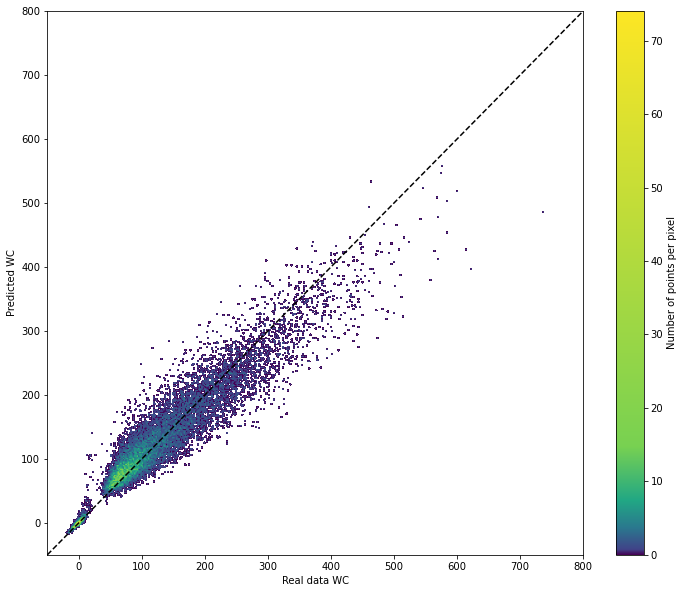

In [21]:
fig = plt.figure(figsize=(12,10))
using_mpl_scatter_density(fig, Y_test, Y_pred_test)

## Voting

In [22]:
ereg = VotingRegressor([('gb', gb), ('rf', rf),('et',et)],weights=(0.6,0.1,0.3))
ereg.fit(X_train, Y_train)

Y_pred_train_v = ereg.predict(X_train)
Y_pred_test_v = ereg.predict(X_test)

In [24]:
print('Voting')
print('RMSE: %.10f'
      % mean_squared_error(Y_train, Y_pred_train_v,squared=False))
print('R^2: %.10f'
      % r2_score(Y_train, Y_pred_train_v))
print('MAE: %.10f'
      % mean_absolute_error(Y_train, Y_pred_train_v))
print('LMAE: %.10f'
      % np.log10(mean_absolute_error(Y_train, Y_pred_train_v)))
print("-------------")
print('RMSE: %.10f'
      % mean_squared_error(Y_test, Y_pred_test_v,squared=False))
print('R^2: %.10f'
      % r2_score(Y_test, Y_pred_test_v))
print('MAE: %.10f'
      % mean_absolute_error(Y_test, Y_pred_test_v))
print('LMAE: %.10f'
      % np.log10(mean_absolute_error(Y_test, Y_pred_test_v)))
print("-------------")

Voting
RMSE: 10.7911848416
R^2: 0.9850993912
MAE: 7.9779674424
LMAE: 0.9018922597
-------------
RMSE: 28.1386136488
R^2: 0.8981721310
MAE: 19.4438606999
LMAE: 1.2887825010
-------------


/Users/chayanonatthapak/Downloads/return/envs/nn_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/chayanonatthapak/Downloads/return/envs/nn_env/lib/python3.9/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


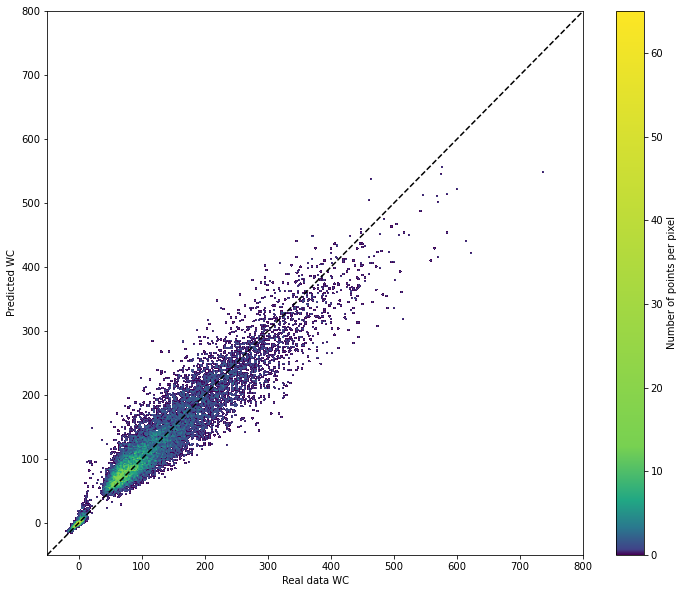

In [25]:
fig = plt.figure(figsize=(12,10))
using_mpl_scatter_density(fig, Y_test ,Y_pred_test_v)

## Prediction of Testset

In [26]:
#Augmentation
noise1 = np.random.normal(0, .002, X_all.shape)
X_all_noise1 = X_all+noise1

In [27]:
X_all_db_n = np.concatenate((X_all, X_all_noise1), axis=0)
Y_all_db = np.concatenate((Y_all, Y_all), axis=0)
print(X_all_db_n.shape)
print(Y_all_db.shape)

(132600, 147)
(132600,)


In [28]:
ereg_1_all_db_n = VotingRegressor([('gb', gb), ('rf', rf),('et',et)],weights=(0.6,0.1,0.3))
ereg_1_all_db_n.fit(X_all_db_n, Y_all_db)

Y_pred_realtest_all_db_n = ereg_1_all_db_n.predict(X_realtest)

In [29]:
#Submis or vote with orther model